In [1]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -qq --upgrade transformers==4.25.1 diffusers ftfy accelerate gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import sys
from base64 import b64encode
import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()
torch_device = "cuda" if torch.cuda.is_available() else "cpu"


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

## CLIP Embeddings

In [4]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [5]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925


In [6]:
def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
    return len(prompt.split())+1

## Stable Diffusion Function

In [16]:
from torchvision.transforms import ToTensor
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None, custom_loss_scale=1.0):


    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5
    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, loss_fn, custom_loss_scale)
                print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [8]:
def generate_image_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn=None, custom_loss_scale=1.0):
    # Find the position of the end of sentence (EOS) in the prompt.
    eos_pos = get_EOS_pos_in_prompt(prompt)

    # Retrieve style token embeddings if a style number is specified.
    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # Tokenize the input text using the tokenizer.
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # Obtain token embeddings from the text model.
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append the style token towards the end of the sentence embeddings if a style is selected.
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # Combine token embeddings with position embeddings.
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    # Feed the input embeddings to get modified output embeddings.
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # Generate an image using the modified embeddings.
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn, custom_loss_scale)

    return generated_image


In [ ]:
"""
def show_image(image):
    plt.imshow(image)"""

In [9]:
def show_images(images_list,image_names):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
        axs[c].set_title(image_names[c])

    plt.show()

### Self Creative Loss

In [10]:
def invert_loss(gen_image):
    inverter = T.RandomInvert(p=1.0)
    inverted_img = inverter(gen_image)
    #loss = torch.abs(gen_image - inverted_img).sum()
    loss = torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,2]) + torch.nn.functional.mse_loss(gen_image[:,2], gen_image[:,1]) + torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,1])
    return loss

def contrast_loss(images):
    # Calculate the variance of pixel values as a measure of contrast.
    variance = torch.var(images)
    return -variance

import torch.nn.functional as F

def gradient_loss(images):
    # Compute gradient magnitude using Sobel filters.
    gradient_x = F.conv2d(images, torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).view(1, 1, 3, 3).to(images.device))
    gradient_y = F.conv2d(images, torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).view(1, 1, 3, 3).to(images.device))
    gradient_magnitude = torch.sqrt(gradient_x**2 + gradient_y**2)
    return gradient_magnitude.mean()


import torch.nn as nn

class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor, weight=1.0):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.criterion = nn.L1Loss()
        self.weight = weight

    def forward(self, input, target):
        input_features = self.feature_extractor(input)
        target_features = self.feature_extractor(target)
        return self.weight * self.criterion(input_features, target_features)

# Usage:
# feature_extractor = your_pretrained_feature_extractor
# perceptual_loss = PerceptualLoss(feature_extractor, weight=1.0)
# loss = perceptual_loss(input_image, target_image)

def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error



In [ ]:
## Inferencing and Loss Selection

In [19]:
  outputs_no_loss = []
  outputs_loss = []
  image_names=["Birb Style","Cute Game Style","Manga Style","Mid Journey Style","Space Style"]
  style_files = ['/content/learned_embeds_birb_style.bin','/content/learned_embeds_cute_game_style.bin',
            '/content/learned_embeds_manga_style.bin','/content/learned_embeds_midjourney_style.bin','/content/learned_embeds_space_style.bin']
  seed_values = [101,102,103,104,105]
  prompt = " An astronaut like a cat"
  custom_loss = contrast_loss
  #custom_loss_= blue_loss
  custom_loss_scale = 100.0
  num_styles = len(style_files)
  for count in range(num_styles):

      generated_img_no_loss = generate_image_custom_style(prompt,
                                                          style_num = count,
                                                          random_seed = seed_values[count],
                                                          custom_loss_fn = None,
                                                          custom_loss_scale = custom_loss_scale)
      outputs_no_loss.append(generated_img_no_loss)
      generated_img_loss = generate_image_custom_style(prompt,
                                                          style_num = count,
                                                          random_seed = seed_values[count],
                                                          custom_loss_fn = custom_loss,
                                                          custom_loss_scale = custom_loss_scale)
      outputs_loss.append(generated_img_loss)


<ipython-input-17-4c8373d1b5b4>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -3.9991438388824463
2 loss: -11.713286399841309
4 loss: -8.24696159362793
6 loss: -7.909416198730469
8 loss: -11.394644737243652
10 loss: -12.222070693969727
12 loss: -13.82325267791748
14 loss: -13.991701126098633
16 loss: -14.652569770812988
18 loss: -15.086664199829102
20 loss: -15.480093955993652
22 loss: -15.489082336425781
24 loss: -15.921401977539062
26 loss: -16.12598991394043
28 loss: -16.230304718017578


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -2.26309871673584
2 loss: -5.561237812042236
4 loss: -7.9041056632995605
6 loss: -5.583949089050293
8 loss: -6.43925666809082
10 loss: -6.054934024810791
12 loss: -6.740528106689453
14 loss: -7.225130558013916
16 loss: -7.588603973388672
18 loss: -7.693591594696045
20 loss: -7.843122482299805
22 loss: -7.927612781524658
24 loss: -8.020195007324219
26 loss: -8.126689910888672
28 loss: -8.245135307312012


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -2.3828864097595215
2 loss: -3.828746795654297
4 loss: -9.535831451416016
6 loss: -11.232330322265625
8 loss: -11.912224769592285
10 loss: -13.625018119812012
12 loss: -12.943567276000977
14 loss: -14.439087867736816
16 loss: -15.538326263427734
18 loss: -17.187395095825195
20 loss: -18.184904098510742
22 loss: -18.743310928344727
24 loss: -19.186697006225586
26 loss: -19.490310668945312
28 loss: -19.738378524780273


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -5.860256671905518
2 loss: -10.0670166015625
4 loss: -10.997270584106445
6 loss: -12.92573070526123
8 loss: -12.685054779052734
10 loss: -13.845902442932129
12 loss: -14.432380676269531
14 loss: -14.875393867492676
16 loss: -14.963485717773438
18 loss: -14.887395858764648
20 loss: -15.19021987915039
22 loss: -15.505067825317383
24 loss: -15.799283981323242
26 loss: -15.88886833190918
28 loss: -16.05437469482422


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: -2.5770790576934814
2 loss: -6.456577777862549
4 loss: -7.667064666748047
6 loss: -8.22745132446289
8 loss: -7.765638828277588
10 loss: -8.402159690856934
12 loss: -10.95155143737793
14 loss: -11.66127872467041
16 loss: -12.277029037475586
18 loss: -13.24276065826416
20 loss: -13.379748344421387
22 loss: -13.46313762664795
24 loss: -13.456787109375
26 loss: -13.448746681213379
28 loss: -13.425562858581543


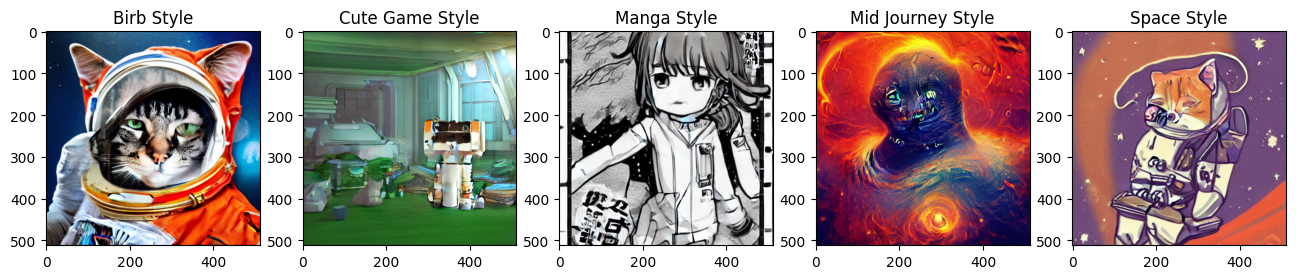

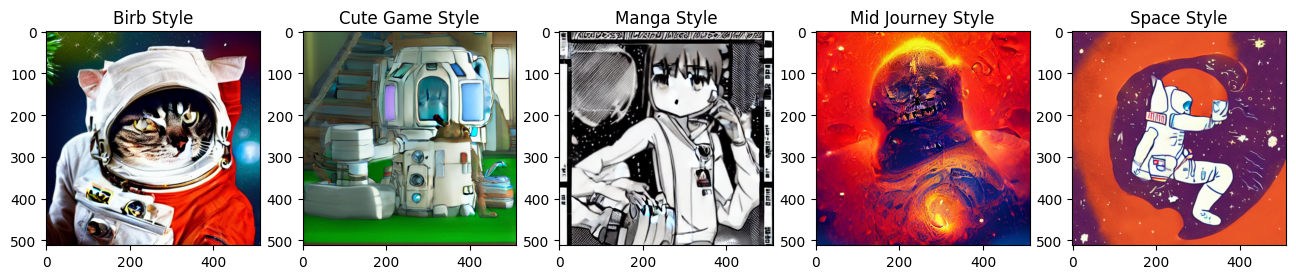

In [13]:
show_images(outputs_no_loss,image_names)
show_images(outputs_loss,image_names)

In [11]:
def generate_image_prompt(prompt):

    outputs_no_loss = []
    outputs_loss = []
    image_names=["Birb Style","Cute Game Style","Manga Style","Mid Journey Style","Space Style"]
    seed_values = [101,102,103,104,105]
    custom_loss = contrast_loss
    #custom_loss = blue_loss
    custom_loss_scale = 100.0
    num_styles = len(style_files)
    for count in range(num_styles):

        generated_img_no_loss = generate_image_custom_style(prompt,
                                                            style_num = count,
                                                            random_seed = seed_values[count],
                                                            custom_loss_fn = None,
                                                            custom_loss_scale = custom_loss_scale)
        outputs_no_loss.append(generated_img_no_loss)
        generated_img_loss = generate_image_custom_style(prompt,
                                                            style_num = count,
                                                            random_seed = seed_values[count],
                                                            custom_loss_fn = custom_loss,
                                                            custom_loss_scale = custom_loss_scale)
        outputs_loss.append(generated_img_loss)

    return outputs_no_loss,outputs_loss

In [12]:

!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5579

In [17]:
import gradio as gr

In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

prompt_examples = [["A cat holding a guitar"],
            ["A dog sitting with a person"],
            ["An Astronaut riding a cycle"],
            ["A astronaut with face of a cat"]]
# Define Interface
description = 'Stable Diffusion is a generative artificial intelligence (generative AI) model that produces unique photorealistic images from text and image prompts.'
title = 'Image Generation using Stable Diffusion'
style_files = ['/content/learned_embeds_birb_style.bin','/content/learned_embeds_cute_game_style.bin',
            '/content/learned_embeds_manga_style.bin','/content/learned_embeds_midjourney_style.bin','/content/learned_embeds_space_style.bin']
demo = gr.Interface(generate_image_prompt,
                    inputs = [gr.Textbox('Prompt Here', label="Text Prompt")],
                    outputs = [gr.Gallery(label='Generated Images with different styles', preview=True, show_label=False, height=300, scale=1),
                               gr.Gallery(label='Generated Images with custom loss (contrast loss) on different styles', preview=True, show_label=False, height=300, scale=1),
                              ],
                    examples=prompt_examples,
                    title = title,
                    description = description
                   )
demo.launch(debug=True,share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://37bc4c4fd5e16208a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<ipython-input-16-d2e92cb0cdee>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 loss: -3.9991207122802734
2 loss: -7.618407726287842


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 loss: -2.263125419616699
2 loss: -5.866994857788086


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 loss: -2.3828914165496826
2 loss: -5.827043056488037


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 loss: -5.860259532928467
2 loss: -9.042298316955566


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 loss: -2.577099323272705
2 loss: -6.250552177429199
